#Mounting the drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
cd drive/My\ Drive/Flickr8k

/content/drive/My Drive/Flickr8k


# Importing Libraries

In [ ]:

import numpy as np
from numpy import array
import pandas as pd
from nltk.translate.bleu_score import corpus_bleu

import matplotlib.pyplot as plt
from keras.layers.wrappers import Bidirectional

%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.preprocessing.image import load_img, img_to_array

from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, Concatenate, Dropout, BatchNormalization,LSTMCell
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Helper functions for pre processing data

In [ ]:
def loadFile(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    data = file.read()
    file.close()
    return data
def loadImgs(filename):
  text = loadFile(filename)
  imgs = list()

  for sentence in text.split("\n"):
    words = sentence.split(".")
    if len(sentence)<1:
      continue
    img_id = words[0]
    imgs.append(img_id)
  return imgs

def loadDict(imgs,fn):
  mappings = dict()
  text = loadFile(fn)
  sentences = text.split("\n")
  for img in imgs:
    mappings[img] = list()
  for sentence in sentences:
    words = sentence.split()
    if(len(sentence))<1:
      continue
    img_id , caption = words[0],words[1:]
    caption = "<startseq> " + " ".join(caption)+" <endseq>"
    if img_id in imgs:
      mappings[img_id].append(caption)
  return mappings

def getVocabulary(mapped_captions):
    vocab = list()
    for key in mapped_captions.keys():
        for sentence in mapped_captions[key]:
          words = sentence.split()
          for word in words:
              if word not in vocab:
                  vocab.append(word)

    return vocab


def cleaningData(desc):
    table = str.maketrans('','',string.punctuation)
    
    for img_id,caption in desc.items():

        for num,img_caption in enumerate(caption):
            
            img_caption.replace("-"," ")

            cap_l = img_caption.split()
            #converts to lowercase
            cap_l = [each.lower() for each in cap_l]
            #remove punctuation from each token
            cap_l = [each.translate(table) for each in cap_l]
            #remove hanging 's and a 
            cap_l = [each for each in cap_l if(len(each)>1)]
            #remove tokens with numbers in them
            cap_l = [each for each in cap_l if(each.isalpha())]

            #convert back to string
            img_caption = ' '.join(cap_l)
            desc[img_id][num]= img_caption
    return desc

def generateDescriptions(data): 
    mapped_captions = dict()
    text = data
    lines = text.split('\n')

    for line in lines:
        words = line.split()
        if len(line)<2:
            continue 
       
        image, caption = words[0], words[1:]
        caption = ' '.join(caption)
        image = image.split('.')
        image = image[0]
      
        if image not in mapped_captions:
            mapped_captions[image] = []

        mapped_captions[image].append(caption)
    return mapped_captions
def saveText(mappings, filename):
    sentences = []

    for img_name, captions in mappings.items():

        for each in captions:
            sentences.append(img_name + '\t' + each)

    text = "\n".join(sentences)
    final_file = open(filename,"w")
    final_file.write(text)
    final_file.close()

In [ ]:



file = "Flickr8k_text/Flickr8k.token.txt"
text = loadFile(file)
print(text[:100])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


In [ ]:
captions = generateDescriptions(text)
captions = cleaningData(captions)
print("Total Captions: "+str(len(captions)))

Total Captions: 8092


In [ ]:

vocab = getVocabulary(captions)
print(len(vocab))

8763


In [ ]:
saveText(captions, "clean.txt")

In [ ]:
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
x_train = loadImgs(filename)
print("Train data: "+str(len(x_train)))

Train data: 6000


In [ ]:
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
x_val = loadImgs(filename)
print("Validation data: "+str(len(x_val)))

Validation data: 1000


In [ ]:
filename = 'Flickr8k_text/Flickr_8k.testImages.txt'
x_test = loadImgs(filename)
print("Test data: "+str(len(x_test)))

Test data: 1000


In [ ]:

train=[]
val = []
test = []

for each in x_train:
  each = each+'.jpg'
  train.append(each)

for each in x_val:
  each = each+'.jpg'
  val.append(each)

for each in x_test:
  each = each+'.jpg'
  test.append(each)

In [ ]:
print(val[0])

2090545563_a4e66ec76b.jpg


# Extracting features of the images using pre-trained Inception V3 model.

In [ ]:
def extractFeatures(images):

  model = InceptionV3(weights='imagenet')  
  model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
  photo_features = dict()
  
  for image in images:
            imagepath = "Flicker8k_Dataset/"+image
            photo = load_img(imagepath, target_size=(299, 299))
            img = img_to_array(photo)
            img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
            img = preprocess_input(img)
            feature = model.predict(img, verbose=0)
            feature = np.reshape(feature, feature.shape[1])
            photo_features[image] = feature
        
  return photo_features

In [ ]:
encoding_train = {}
encoding_train = extractFeatures(train)
with open("encoded_train_imagesh.pkl", "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

In [ ]:
encoding_val = {}
encoding_val = extractFeatures(val)
with open("encoded_val_imagesh.pkl", "wb") as encoded_pickle:
    dump(encoding_val, encoded_pickle)

In [ ]:
encoding_test = {}
encoding_test = extractFeatures(test)
with open("encoded_test_imagesh.pkl", "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

In [ ]:
train_features = load(open("encoded_train_imagesh.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [ ]:
val_features = load(open("encoded_val_imagesh.pkl", "rb"))
print('Photos: val=%d' % len(val_features))
print(val_features["1579798212_d30844b4c5.jpg"].shape)

Photos: val=1000
(2048,)


In [ ]:
test_features = load(open("encoded_test_imagesh.pkl", "rb"))
print('Photos: val=%d' % len(test_features))
print(test_features['241347760_d44c8d3a01.jpg'].shape)

Photos: val=1000
(2048,)


In [ ]:
train_data = loadDict(x_train,'clean.txt')
val_data = loadDict(x_val,'clean.txt')

In [ ]:
train_caption = []
for key, captions in train_data.items():
    for caption in captions:
        train_caption.append(caption)
print(len(train_caption))

30000


In [ ]:
print(train_caption[:5])

['<startseq> black dog is running after white dog in the snow <endseq>', '<startseq> black dog chasing brown dog through snow <endseq>', '<startseq> two dogs chase each other across the snowy ground <endseq>', '<startseq> two dogs play together in the snow <endseq>', '<startseq> two dogs running through low lying body of water <endseq>']


# Reducing the vocabulary size

In [ ]:
threshold = 3
word_counts = {}
nsents = 0
for sent in train_caption:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocabulary = [word for word in word_counts if word_counts[word] >= threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocabulary)))
vocab_len = len(vocabulary)+1

preprocessed words 7578 -> 3471


In [ ]:
idx2word = dict()
word2idx = dict()

idx = 1
for word in vocabulary:
    word2idx[word] = idx
    idx2word[idx] = word
    idx += 1

In [ ]:
print(idx2word[1])


<startseq>


In [ ]:
print(word2idx['ground'])

22


In [ ]:
def getMax(mappings):
    mappings_l = list()
    for key in mappings.keys():
      [mappings_l.append(each) for each in mappings[key]]
    max = len(mappings_l[0].split())
    for caption in mappings_l:
      if(len(caption.split())>max):
        max = len(caption.split())
    return max
max = getMax(train_data)
print('Maximum caption length: %d' % max)

Maximum caption length: 34


# Using data generator due to limitations of RAM

In [ ]:
def data_generator(mappings, features, word2idx, max_length, batch_size):
    X1, X2, y = list(), list(), list()
    count=0
    # loop for ever over images
    while True:
        for img, capts in mappings.items():
            count+=1
            # retrieve the photo feature
            feature = features[img+'.jpg']
            for caption in capts:
                # encode the sequence
                seq = [word2idx[word] for word in caption.split(' ') if word in word2idx]
                # split one sequence into multiple X, y pairs
                for n in range(1, len(seq)):
                    # split into input and output pair
                    partial,cap = seq[:n], seq[n]
                    # pad input sequence
                    #print(partial)
                    partial = pad_sequences([partial], maxlen=max_length,padding='post')[0]
                    # encode output sequence
                    cap = to_categorical([cap], num_classes=vocab_len)[0]
                    # store
                    X1.append(feature)
                    X2.append(partial)
                    y.append(cap)
            # yield the batch data
            if count==batch_size:
                yield [array(X1), array(X2),np.zeros([array(X2).shape[0],256]),np.zeros([array(X2).shape[0],256])], array(y)
                X1, X2, y = list(), list(), list()
                count=0

#Defining model
Extracted image features are fed into the LSTM at the first time step.
The respective caption is fed word by word afterwards.

In [ ]:
embedding_size = 128
image_model = Sequential()
image_model.add(Input(shape=(2048,)))
image_model.add(BatchNormalization(axis=-1))
image_model.add(Dropout(0.5))
image_model.add(Dense(embedding_size, activation='relu'))
image_model.add(RepeatVector(1))
image_model.summary()

language_model = Sequential()
language_model.add(Input(shape=(max,)))
language_model.add(Embedding(input_dim=vocab_len, output_dim=embedding_size,mask_zero=True, input_length=max))
language_model.add(Dropout(0.5))
language_model.summary()
inp = image_model.output

a0 = Input(shape=(256,))
c0 = Input(shape=(256,))

b1 = BatchNormalization()(inp)
b2 = BatchNormalization()(language_model.output)
LSTMlayer= LSTM(256,return_sequences=False,return_state=True,dropout=0.5,recurrent_dropout=0.5)

_ , a ,c = LSTMlayer(b1,initial_state=[a0,c0])

A, _ ,_ = LSTMlayer(b2,initial_state = [a,c]) 
sequence_output = Dense(units=vocab_len,activation='softmax')(A)

model = Model(inputs=[image_model.input, language_model.input,a0,c0],
              outputs=sequence_output)
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_45 (Batc (None, 2048)              8192      
_________________________________________________________________
dropout_30 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               262272    
_________________________________________________________________
repeat_vector_15 (RepeatVect (None, 1, 128)            0         
Total params: 270,464
Trainable params: 266,368
Non-trainable params: 4,096
_________________________________________________________________
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 34, 128)           444416    
____________________

In [ ]:
generator = data_generator(train_data, train_features, word2idx, max,1)
inputs,outputs = next(generator)
print(outputs.shape)
print(inputs[0].shape)
print(outputs[0].shape)
print(inputs[1].shape)


(47, 3472)
(47, 2048)
(3472,)
(47, 34)


In [ ]:
model.optimizer.lr = 0.001

epochs = 8
batch_len = 25
val_batch = 5
steps = len(train_data)//batch_len
val_steps = len(val_data)//val_batch
for i in range(epochs):
    
    generator = data_generator(train_data, train_features, word2idx, max,batch_len )
    val_gen = data_generator(val_data, val_features, word2idx, max,val_batch )

    model.fit(generator, epochs=1, steps_per_epoch=steps,validation_data=val_gen,validation_steps=val_steps, verbose=1)

240/240 [==============================] - 70s 292ms/step - loss: 3.3852 - accuracy: 0.3120 - val_loss: 3.4490 - val_accuracy: 0.3122


In [ ]:
for i in range(3):
    
    generator = data_generator(train_data, train_features, word2idx, max,batch_len )
    val_gen = data_generator(val_data, val_features, word2idx, max,val_batch )

    model.fit(generator, epochs=1, steps_per_epoch=steps,validation_data=val_gen,validation_steps=val_steps, verbose=1)

240/240 [==============================] - 70s 292ms/step - loss: 3.2334 - accuracy: 0.3257 - val_loss: 3.3734 - val_accuracy: 0.3214


In [ ]:
model.optimizer.lr = 0.0001
epochs = 3
batch_len = 30
val_batch = 5
steps = len(train_data)//batch_len
val_steps = len(val_data)//val_batch

for i in range(3):
    
    generator = data_generator(train_data, train_features, word2idx, max,batch_len )
    val_gen = data_generator(val_data, val_features, word2idx, max,val_batch )

    model.fit(generator, epochs=1, steps_per_epoch=steps,validation_data=val_gen,validation_steps=val_steps, verbose=1)

200/200 [==============================] - 63s 315ms/step - loss: 3.1262 - accuracy: 0.3365 - val_loss: 3.3394 - val_accuracy: 0.3264


In [ ]:
model.save_weights('paper.h5')

# Evaluating the model using bleu score.

In [ ]:
def evaluate_model(descriptions, photos):
	actual, predicted = list(), list()

	for key, desc_list in descriptions.items():
#beamSearch(image,beam_index=5)
		yhat = greedySearch(photos[key+'.jpg'])
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
  
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
 
evaluate_model(val_data,val_features)

BLEU-1: 0.454360
BLEU-2: 0.264549


# Defining helper functions for performing prediction by beamSearch and argmax search

In [ ]:
 def beamSearch(image, beam_index):
    start = [word2idx["<startseq>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max,padding='post')
            image = image.reshape((1,2048))
            preds = model.predict([image, par_caps,np.zeros([array(par_caps).shape[0],512]),np.zeros([array(par_caps).shape[0],512])])
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)

                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp

        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    for i in intermediate_caption:
        if i != '<endseq>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
model.load_weights('paper.h5')

In [ ]:
with open("encoded_test_imagesh.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)
def greedySearch(photo):
    in_text = '<startseq>'
    for i in range(max):
        sequence = [word2idx[w] for w in in_text.split() if w in word2idx]
        photo = photo.reshape((1,2048))
        sequence = pad_sequences([sequence], maxlen=max,padding='post')
        
        yhat = model.predict([photo,sequence,np.zeros([array(sequence).shape[0],256]),np.zeros([array(sequence).shape[0],256])], verbose=0)
        yhat = np.argmax(yhat)
        word = idx2word[yhat]
        in_text += ' ' + word

        if word == '<endseq>':
            break

    final = in_text.split()
    final = ' '.join(final[1:-1])
    return final

# Making predictions

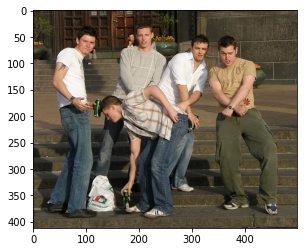

Beam Index 5: group of people stand in front of brick wall
Beam index 7: group of people are standing in front of brick wall
Greedy:  man and woman sit on bench


In [ ]:
z= 50
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread('Flicker8k_Dataset/'+pic)
plt.imshow(x)
plt.show()

print("Beam Index 5: "+beamSearch(image,beam_index=5))
print("Beam index 7: "+beamSearch(image,beam_index=7))
print("Greedy: ",greedySearch(image))

In [ ]:
model.save_weights('paper2.h5')